In [1]:
# Adapted from https://github.com/pytorch/vision/blob/v0.4.0/torchvision/models/resnet.py
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.data import AUTOTUNE

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

In [2]:
img_height = 256
img_width = 256
image_dir = "images"
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    labels="inferred",
    class_names=["Austria","Australia"],
    subset="both",
    seed = 0,
    batch_size = batch_size,
    crop_to_aspect_ratio=True,
    image_size=(img_height, img_width))

Found 25064 files belonging to 2 classes.
Using 20052 files for training.
Using 5012 files for validation.


In [3]:

model = keras.Sequential(
    [
    layers.Conv2D(8, (3,3), input_shape = (img_height,img_width,3), activation = "relu", padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(16, (3,3), padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(32, (3,3), padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(64, (3,3), padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Conv2D(64, (3,3), padding="same"),
    layers.MaxPooling2D((2,2), padding="same"),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(1, activation = 'sigmoid'),
    ])

optimizer = optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ["accuracy"])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0

In [5]:
def standardize_image(image, label):
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    standardized_image = tf.map_fn(lambda x: (x - mean)/std, image)
    return (standardized_image, label)

train_ds =  train_ds.map(standardize_image)
val_ds = val_ds.map(standardize_image)


train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
627/627 [==============================] - 542s 861ms/step - loss: 0.3962 - accuracy: 0.8157 - val_loss: 0.3398 - val_accuracy: 0.8625
Epoch 2/10
627/627 [==============================] - 522s 830ms/step - loss: 0.2794 - accuracy: 0.8815 - val_loss: 0.2532 - val_accuracy: 0.8962
Epoch 3/10
627/627 [==============================] - 522s 831ms/step - loss: 0.2292 - accuracy: 0.9059 - val_loss: 0.2283 - val_accuracy: 0.9054
Epoch 4/10
627/627 [==============================] - 25257s 40s/step - loss: 0.1875 - accuracy: 0.9233 - val_loss: 0.2319 - val_accuracy: 0.9084
Epoch 5/10
627/627 [==============================] - 599s 954ms/step - loss: 0.1519 - accuracy: 0.9395 - val_loss: 0.2303 - val_accuracy: 0.9136
Epoch 6/10
627/627 [==============================] - 535s 851ms/step - loss: 0.1224 - accuracy: 0.9516 - val_loss: 0.2673 - val_accuracy: 0.9082
Epoch 7/10
627/627 [==============================] - 663s 1s/step - loss: 0.0972 - accuracy: 0.9623 - val_loss: 0.2906 - va

In [7]:
model.save("neural_network")

INFO:tensorflow:Assets written to: neural_network\assets


INFO:tensorflow:Assets written to: neural_network\assets


In [10]:
model.evaluate(val_ds)

157/157 [==============================] - 65s 413ms/step - loss: 0.3767 - accuracy: 0.9108


[0.3767438530921936, 0.9108140468597412]

1/1 [==============================] - 1s 1s/step
0.90625
1/1 [==============================] - 0s 329ms/step
0.96875
1/1 [==============================] - 0s 349ms/step
0.96875
1/1 [==============================] - 0s 343ms/step
0.9375
1/1 [==============================] - 0s 326ms/step
0.875


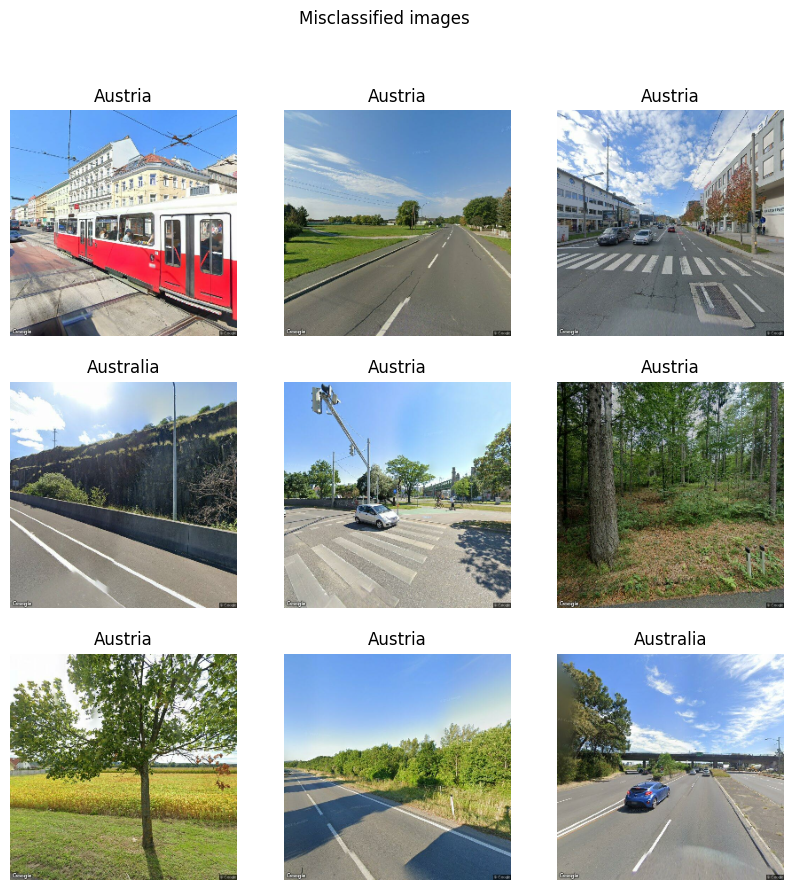

In [8]:
plt.figure(figsize=(10, 10))
class_names = ["Austria", "Australia"]
i = 1
for images, labels in val_ds.take(10):
    predictions = model.predict(images).reshape((32,))
    predicted_labels = np.where(predictions > 0.5, 1,0)
    actual_labels = labels.numpy()
    prediction_results = (predicted_labels == actual_labels)
    print(sum(prediction_results)/32)
    for image, predicted_label, actual_label in zip(images, predicted_labels, actual_labels):
        if predicted_label != actual_label:
            ax = plt.subplot(3, 3, i)
            image = image.numpy()
            image_min = np.min(image)
            image_max = np.max(image)
            image = (image - (image_min + image_max)/2)/(image_max - image_min) + 1/2
            plt.imshow(image)
            plt.title(class_names[actual_label])
            plt.axis("off")
            i += 1
        if i > 9:
            break
    if i > 9:
        break
plt.suptitle("Misclassified images")
plt.show()       
